# Workshop hands-on

The proposed exercise here will guide you through two simple examples using
the [S-PLUS DR4][1]. For the execution of this hands-on, you will follow 
some of the documentation and code examples given during the first part of 
this workshop. In particular, we will use [LSDB][2], [splusdata][3] and some 
common Python libraries like [NumPy][4] (for calculations) and 
[Matplotlib][5] (for plots). In addition to the mentioned technical tools, 
the exercise require data from the the S-PLUS DR4, associated VACs and the 
[GAIA DR3 catalog][6].

## Proposed science cases:

>1. Create a [galaxy CMD][7] (e.g., *g-r* vs *r*) diagram for galaxies identified by
the [S-PLUS DR4 QSO/star/galaxy VAC][8] and make a *mag* vs *filter* plot for the
5 objects with higher **J0660** magnitude.
>2. Create an [observational H.R. Diagram][9] for stars identified by the same
catalog, crossmatching with [GAIA DR3 catalog][6] for the desired region.

## Additional information

- For both cases, the choice of the celestial coordinates (right ascencion and 
Declination) and cone-search radius are free. 
- The [S-PLUS DR4][1] provides data for six different appertures (*PStotal*,
*aper_3*, *aper_6*, *auto*, *petro* and *iso*).
> The suggestion is to use **PStotal** aperture when available. Read more
about the different appertures and photometry modes at [S-PLUS DR4 paper][1] 
or [S-PLUS DR4 on-line documentation][10].
- Look for the code examples given at last classes.
- [GAIA DR3][6] has a HiPSCat to use with [LSDB][2] with some limitations.
> Read more about GAIA DR3 HiPSCat: <https://data.lsdb.io/>

[1]: <https://www.aanda.org/articles/aa/pdf/forth/aa49725-24.pdf> "The Fourth S-PLUS Data Release: 12-filter photometry covering ~3000 square degrees in the southern hemisphere"
[2]: <https://lsdb.readthedocs.io/en/stable/> "Large Survey DataBase python framework"
[3]: <https://github.com/Schwarzam/splusdata> "S-PLUS data python package"
[4]: <https://numpy.org/> "NumPy: scientific computing with Python"
[5]: <https://matplotlib.org/> "Matplotlib: Visualization with Python"
[6]: <https://www.cosmos.esa.int/web/gaia/data-release-3> "GAIA Data Release 3"
[7]: <https://en.wikipedia.org/wiki/Galaxy_color%E2%80%93magnitude_diagram> "Galaxy color-magnitude diagram"
[8]: <https://splus.cloud/documentation/DR4?QSO/star/galaxy_classification> "QSO/star/galaxy classification VAC"
[9]: <https://en.wikipedia.org/wiki/Hertzsprung%E2%80%93Russell_diagram#/media/File:HRDiagram.png> "Observational Hertzsprung-Russel Diagram"
[10]: <https://splus.cloud/documentation/DR4> "S-PLUS DR4 on-line documentation"

<hr>

# Solution for the fist science case

In [1]:
# needed Python imports
# imports for data retrieve
import lsdb
import splusdata
from dask.distributed import Client
# imports for plot and calculation
import numpy as np
from matplotlib import pyplot as plt

# auxiliar functions and variables
splus_bands = [
    'u', 'g', 'r', 'i', 'z', 
    'J0378', 'J0395', 'J0410',
    'J0430', 'J0515', 'J0660', 'J0861',
]
def print_dict(d, i=0):
    for k, v in d.items():
        print('\t'*i + str(k))
        if isinstance(v, dict):
            print_dict(v, i+1)
        else:
            print('\t'*(i+1) + str(v))

# Start a Dask client for the parallel process used by lsdb
client = Client(n_workers=10, memory_limit='8GB')
print(client) 

# List HiPSCat catalogs available on S-PLUS servers
print_dict(splusdata.get_hipscats())

<Client: 'tcp://127.0.0.1:44083' processes=10 threads=20, memory=74.51 GiB>
dr4_vacs
	qso_z
		hipscats
			['qso_z']
		margins
			['qso_z_2arcsec']
	photozs
		hipscats
			['photozs']
		margins
			['photozs_2arcsec']
	calib_flag
		hipscats
			['calib_flag']
		margins
			['calib_flag_2arcsec']
	sqg
		hipscats
			['sqg']
		margins
			['sqg_2arcsec']
sdr1
	hipscats
		['shorts']
	margins
		['shorts_2arcsec']
dr4
	hipscats
		['single', 'dual', 'psf']
	margins
		['psf_2arcsec', 'single_2arcsec', 'dual_2arcsec']


In [2]:
# search for the full S-PLUS DR4/dual mode catalog
dr4dual_search = splusdata.get_hipscats('dr4/dual')
'''
Here we search for the DR4 data with dual photomery mode.

From S-PLUS DR4 FAQ: (https://splus.cloud/documentation/DR4?FAQ)

    What is the difference between ‘single’, ‘dual’ and ‘psf’?
    
    Single yields photometry done using Sextractor on each image, 
    for a given filter, using only that image as a detection image. 
    Note that in this case, measured parameters such as radii are 
    different for each filter. Dual yields photometry done using 
    Sextractor on each image, for a given filter, using as a 
    detection image the sum of g+r+i+z. Therefore, in dual mode, 
    detections characterized in the same way are measured in every 
    filter. Psf yields photometry done using dophot on each image, 
    for a given filter, using only that image as a detection image. 
    See Section ‘Photometry’ for more details.
    
    Photometry Section: 
        https://splus.cloud/documentation/DR4?Photometry
'''
# Print all catalogs found with the pattern above
print(f'dr4/dual search: {dr4dual_search}')
# select the first catalog found
dr4dual_hipscat, dr4dual_margin_cache_hipscat = dr4dual_search[0]

# Search for the DR4 Star Galaxy Quasar VAC
'''
QSO/star/galaxy classification VAC: 
    https://splus.cloud/documentation/DR4?QSO/star/galaxy_classification
'''
dr4sqg_search = splusdata.get_hipscats('dr4/sqg')
# Print all catalogs found with the pattern above
print(f'dr4/sqg search: {dr4sqg_search}')
# select the first catalog found
dr4sqg_hipscat, dr4sqg_margin_cache_hipscat = dr4sqg_search[0]

dr4/dual search: [['https://splus.cloud/HIPS/catalogs/dr4/dual', 'https://splus.cloud/HIPS/catalogs/dr4/dual_2arcsec']]
dr4/sqg search: [['https://splus.cloud/HIPS/catalogs/dr4_vacs/sqg/sqg', 'https://splus.cloud/HIPS/catalogs/dr4_vacs/sqg/sqg_2arcsec']]


In [3]:
# Create the columns list to retrieve only necessaries columns
'''
We use here choose the magnitudes from 'auto' apperture mode.

Read mode about:
     https://splus.cloud/documentation/DR4?Photometry
'''
columns = ['ID', 'Field', 'RA', 'DEC'] + [f'{b}_auto' for b in splus_bands] + [f's2n_{b}_auto' for b in splus_bands]
print('Columns:', columns)

filters = [(f's2n_{b}_auto', '>', 3) for b in splus_bands]
print('Filters', filters)

Columns: ['ID', 'Field', 'RA', 'DEC', 'u_auto', 'g_auto', 'r_auto', 'i_auto', 'z_auto', 'J0378_auto', 'J0395_auto', 'J0410_auto', 'J0430_auto', 'J0515_auto', 'J0660_auto', 'J0861_auto', 's2n_u_auto', 's2n_g_auto', 's2n_r_auto', 's2n_i_auto', 's2n_z_auto', 's2n_J0378_auto', 's2n_J0395_auto', 's2n_J0410_auto', 's2n_J0430_auto', 's2n_J0515_auto', 's2n_J0660_auto', 's2n_J0861_auto']
Filters [('s2n_u_auto', '>', 3), ('s2n_g_auto', '>', 3), ('s2n_r_auto', '>', 3), ('s2n_i_auto', '>', 3), ('s2n_z_auto', '>', 3), ('s2n_J0378_auto', '>', 3), ('s2n_J0395_auto', '>', 3), ('s2n_J0410_auto', '>', 3), ('s2n_J0430_auto', '>', 3), ('s2n_J0515_auto', '>', 3), ('s2n_J0660_auto', '>', 3), ('s2n_J0861_auto', '>', 3)]


In [4]:
# Read more about the need of the margin cache server at:
#      https://lsdb.readthedocs.io/en/stable/tutorials/margins.html    
dr4dual_margin = lsdb.read_hipscat(dr4dual_margin_cache_hipscat)
dr4sqg_margin = lsdb.read_hipscat(dr4sqg_margin_cache_hipscat)

# Read DR4 dual HiPSCAT
dr4dual = lsdb.read_hipscat(
    dr4dual_hipscat,
    margin_cache=dr4dual_margin,
    # Read more about the available columns at:
    #      https://splus.cloud/documentation/DR4?Schemas,_tables_and_columns
    columns=columns,
    #filters=filters,
)

# Read DR4 QSO/star/galaxy classification VAC HiPSCAT
# Here we filter only objects where the galaxy probability
# is greater than 80%
dr4sqg = lsdb.read_hipscat(
    dr4sqg_hipscat,
    margin_cache=dr4sqg_margin,
    filters=[('PROB_STAR', '>', 0.8)],
)

/home/lacerda/.local/lib/python3.10/site-packages/hipscat/io/file_io/file_io.py:320: UserWarning: point_map.fits file written in RING ordering, due to https://github.com/astronomy-commons/hipscat/issues/271. Converting to NESTED.
  warnings.warn(


In [5]:
# Do the crossmatch of both catalogs. 
identity_radius = 1  # arcsec
dr4dualsqg_crosmatch = dr4sqg.crossmatch(dr4dual, radius_arcsec=identity_radius)

In [6]:
# Let's get the resultant table using a cone search:
cone_center_coord = (201.6912083, -47.476861) # RA and DEC in degrees
cone_radius = 2*3600 # arcsec
objects_table = dr4dualsqg_crosmatch.cone_search(ra=cone_center_coord[0], dec=cone_center_coord[1], radius_arcsec=cone_radius).compute()

Text(0.5, 0, 'DEC_dual')

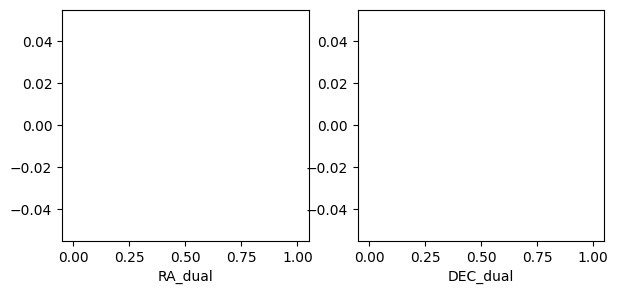

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2)
f.set_size_inches(7, 3)
selection = objects_table['s2n_r_auto_dual'] > 10
ra = objects_table['RA_dual']
dec = objects_table['DEC_dual']
x = cone_radius/3600
ra_range = cone_center_coord[0]+np.array([-1.25*x, 1.25*x])
dec_range = cone_center_coord[1]+np.array([-1.25*x, 1.25*x])
ax1.hist(ra[selection], bins=35)  #, range=ra_range)
ax1.set_xlabel('RA_dual')
ax2.hist(dec[selection], bins=35)  #, range=dec_range)
ax2.set_xlabel('DEC_dual')

Text(0, 0.5, '(g - r)_auto')

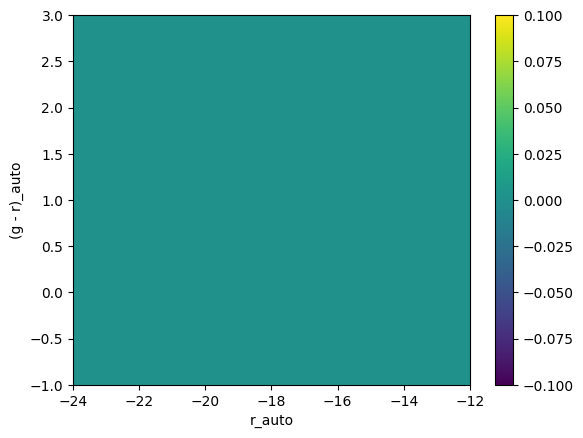

In [8]:
g_r = objects_table['g_auto_dual'] - objects_table['r_auto_dual']
r = objects_table['r_auto_dual']
SNr = objects_table['s2n_r_auto_dual']

SN = 10
mask = (objects_table['s2n_r_auto_dual'] > SN) | (objects_table['s2n_g_auto_dual'] > SN)
mr = np.ma.masked_array(r, mask)
mg_r = np.ma.masked_array(g_r, mask)
mSNr = np.ma.masked_array(SNr, mask)
f, ax = plt.subplots()
#im = ax.hexbin(-mM, mc, bins=50, extent=[-23, -18, 0, 2])
_, _, _, im = ax.hist2d(-mr, mg_r, bins=50, range=[[-24, -12], [-1, 3]])
plt.colorbar(im, ax=ax)
#ax.set_xlim(-23, -10)
#ax.set_ylim(0, 3)
ax.set_xlabel('r_auto')
ax.set_ylabel('(g - r)_auto')

In [1]:
from astropy.coordinates import SkyCoord

In [2]:
ra = '13h26m45.89s'
dec = '-47°28′36.7″'
c = SkyCoord(ra, dec)

In [7]:
c.dec.value

-47.47686111111111